
# Malware Detection — Training & Evaluation (Notebook)

This notebook loads the cleaned dataset from `EDA/Cleaned_malware_dataset.csv` and runs:
- **Classification**: Logistic Regression (scaled), SVM (scaled), Random Forest (unconstrained & constrained)
- **Clustering**: K-Means (k=2), DBSCAN
- Reports metrics: Accuracy, Precision, Recall, F1, ROC AUC (classifiers) and Silhouette, ARI (clustering)
- Prints top Random Forest feature importances



In [1]:
# Essentials
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

DATA_PATH = "EDA/Cleaned_malware_dataset.csv"
print("Reading:", DATA_PATH)


Reading: EDA/Cleaned_malware_dataset.csv


In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH)

to_drop = [c for c in df.columns if str(c).lower().startswith("unnamed") or str(c).strip() == ""]
if to_drop:
    df = df.drop(columns=to_drop)
    print("Dropped:", to_drop)

for col in ["hash", "id", "pid", "process_id", "timestamp", "millisecond"]:
    if col in df.columns:
        print("Dropping identifier/time column:", col)
        df = df.drop(columns=[col])

print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())


Dropped: ['Unnamed: 0']
Dropping identifier/time column: millisecond
Shape: (100000, 22)
Columns: ['classification', 'state', 'prio', 'static_prio', 'vm_truncate_count', 'free_area_cache', 'mm_users', 'map_count', 'total_vm', 'shared_vm', 'exec_vm', 'reserved_vm', 'end_data', 'last_interval', 'nvcsw', 'nivcsw', 'min_flt', 'maj_flt', 'fs_excl_counter', 'utime', 'stime', 'gtime']


,classification,state,prio,static_prio,vm_truncate_count,free_area_cache,mm_users,map_count,total_vm,shared_vm,...,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,utime,stime,gtime
0,1,-0.168526,-1.105059,-0.848177,-0.657076,0.309909,724,-0.507528,150,120,...,120,3473,-0.695251,-0.625663,-0.147906,120,-0.513406,-0.465838,4,-0.509166
1,1,-0.168526,-1.105059,-0.848177,-0.657076,0.309909,724,-0.507528,150,120,...,120,3473,-0.695251,-0.625663,-0.147906,120,-0.513406,-0.465838,4,-0.509166
2,1,-0.168526,-1.105059,-0.848177,-0.657076,0.309909,724,-0.507528,150,120,...,120,3473,-0.695251,-0.625663,-0.147906,120,-0.513406,-0.465838,4,-0.509166
3,1,-0.168526,-1.105059,-0.848177,-0.657076,0.309909,724,-0.507528,150,120,...,120,3473,-0.695251,-0.625663,-0.147906,120,-0.513406,-0.465838,4,-0.509166
4,1,-0.168526,-1.105059,-0.848177,-0.657076,0.309909,724,-0.507528,150,120,...,120,3473,-0.695251,-0.625663,-0.147906,120,-0.513406,-0.465838,4,-0.509166


In [3]:
# Ensure label column exists
if "classification" not in df.columns:
    raise ValueError("Expected 'classification' column. Found: " + str(list(df.columns)))

X = df.drop(columns=["classification"]).copy()
y = df["classification"].astype(int)

assert "classification" not in X.columns, "Label leaked into features!"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (80000, 21)  Test: (20000, 21)


In [4]:
## Utility function to report classifier performance
def report_classifier(name, y_true, y_pred, y_prob=None):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    if y_prob is not None:
        try:
            print("ROC AUC:", roc_auc_score(y_true, y_prob))
        except Exception:
            pass
    print("\nClassification report:\n", classification_report(y_true, y_pred))



=== Logistic Regression (scaled) ===
Accuracy: 0.9359
Precision: 0.9195380173243504
Recall: 0.9554
F1: 0.937126042177538
ROC AUC: 0.98189341

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93     10000
           1       0.92      0.96      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



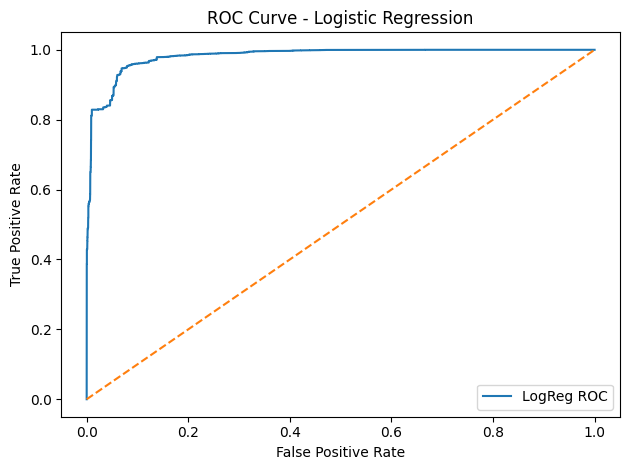

In [5]:
# Logistic Regression (scaled)
scaler_lr = StandardScaler()
X_train_lr = scaler_lr.fit_transform(X_train)
X_test_lr  = scaler_lr.transform(X_test)

logreg = LogisticRegression(max_iter=5000, solver="saga", n_jobs=-1)
logreg.fit(X_train_lr, y_train)
y_pred_lr = logreg.predict(X_test_lr)
y_prob_lr = logreg.predict_proba(X_test_lr)[:, 1]
report_classifier("Logistic Regression (scaled)", y_test, y_pred_lr, y_prob_lr)

fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure()
plt.plot(fpr, tpr, label="LogReg ROC")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Support Vector Machine (RBF Kernel)
scaler_svm = StandardScaler()
X_train_svm = scaler_svm.fit_transform(X_train)
X_test_svm  = scaler_svm.transform(X_test)

svm = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
svm.fit(X_train_svm, y_train)
y_pred_svm = svm.predict(X_test_svm)
y_prob_svm = svm.predict_proba(X_test_svm)[:, 1]
report_classifier("SVM RBF (scaled)", y_test, y_pred_svm, y_prob_svm)

fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
plt.figure()
plt.plot(fpr, tpr, label="SVM ROC")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve

cal_rf = CalibratedClassifierCV(rf_c, method="isotonic", cv=3)
cal_rf.fit(X_train, y_train)
probs = cal_rf.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, probs)

best_idx = (2 * (prec * rec) / (prec + rec + 1e-9)).argmax()
best_thr = thr[best_idx]
print("Best threshold by F1 (calibrated RF):", best_thr)


Best threshold by F1 (calibrated RF): 0.5744221351770163



=== Random Forest (unconstrained) ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Top 15 RF feature importances:
static_prio                    0.2312
free_area_cache                0.1117
utime                          0.1056
nvcsw                          0.1022
maj_flt                        0.0486
exec_vm                        0.0469
vm_truncate_count              0.0447
end_data                       0.0436
shared_vm                      0.0418
mm_users                       0.0329
map_count                      0.0320
last_interval                  0.0303
prio                           0.0284
reserved_vm          

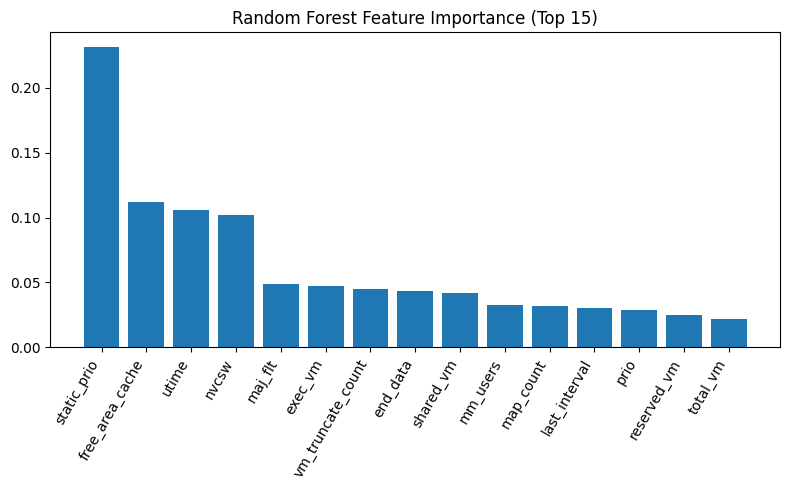

In [ ]:

# Random Forest (unconstrained)
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
report_classifier("Random Forest (unconstrained)", y_test, y_pred_rf, y_prob_rf)

importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:15]
top_feats = [X.columns[i] for i in idx]
print("\nTop 15 RF feature importances:")
for name, val in zip(top_feats, importances[idx]):
    print(f"{name:30s} {val:.4f}")

plt.figure(figsize=(8,5))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), top_feats, rotation=60, ha='right')
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


In [ ]:

# Random Forest (constrained)
rf_c = RandomForestClassifier(
    n_estimators=300, max_depth=6, min_samples_leaf=5, random_state=42, n_jobs=-1
)
rf_c.fit(X_train, y_train)
y_pred_rf_c = rf_c.predict(X_test)
y_prob_rf_c = rf_c.predict_proba(X_test)[:, 1]
report_classifier("Random Forest (constrained)", y_test, y_pred_rf_c, y_prob_rf_c)



=== Random Forest (constrained) ===
Accuracy: 0.9881
Precision: 1.0
Recall: 0.9762
F1: 0.9879566845460985
ROC AUC: 0.9998021800000001

Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10000
           1       1.00      0.98      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



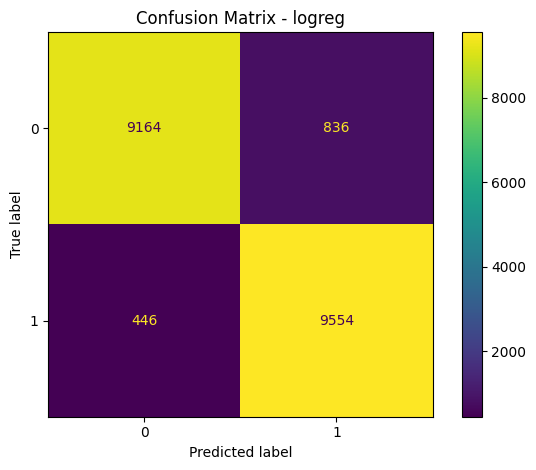

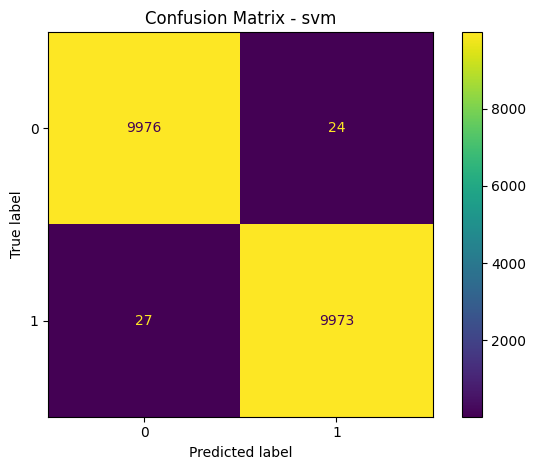

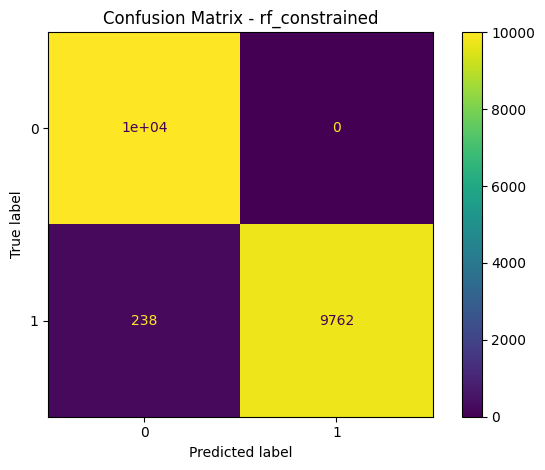

In [ ]:
# Confusion Matrices
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

os.makedirs("artifacts/plots", exist_ok=True)

for name, y_pred in [
    ("logreg", y_pred_lr),
    ("svm", y_pred_svm),
    ("rf_constrained", y_pred_rf_c),
]:
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.savefig(f"artifacts/plots/cm_{name}.png", dpi=160, bbox_inches="tight")
    plt.show()


In [ ]:
# Clustering: K-Means and DBSCAN
scaler_km = StandardScaler()
X_km = scaler_km.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels_km = kmeans.fit_predict(X_km)
sil_km = silhouette_score(X_km, cluster_labels_km)
ari_km = adjusted_rand_score(y, cluster_labels_km)
print("\n=== K-Means (k=2) ===")
print("Silhouette Score:", sil_km)
print("Adjusted Rand Index (vs label):", ari_km)

dbscan = DBSCAN(eps=0.8, min_samples=15, n_jobs=-1)
cluster_labels_db = dbscan.fit_predict(X_km)

valid_mask = cluster_labels_db != -1
if valid_mask.sum() > 1 and len(set(cluster_labels_db[valid_mask])) > 1:
    sil_db = silhouette_score(X_km[valid_mask], cluster_labels_db[valid_mask])
    ari_db = adjusted_rand_score(y[valid_mask], cluster_labels_db[valid_mask])
else:
    sil_db = float("nan")
    ari_db = float("nan")

unique, counts = np.unique(cluster_labels_db, return_counts=True)
print("\n=== DBSCAN ===")
print("Cluster distribution (label -> count):", dict(zip(unique, counts)))
print("Silhouette Score (non-noise only):", sil_db)
print("Adjusted Rand Index (non-noise only):", ari_db)



=== K-Means (k=2) ===
Silhouette Score: 0.3227804482922663
Adjusted Rand Index (vs label): 0.004058566888651653

=== DBSCAN ===
Cluster distribution (label -> count): {np.int64(-1): np.int64(1644), np.int64(0): np.int64(972), np.int64(1): np.int64(26), np.int64(2): np.int64(43), np.int64(3): np.int64(26), np.int64(4): np.int64(39), np.int64(5): np.int64(913), np.int64(6): np.int64(49), np.int64(7): np.int64(148), np.int64(8): np.int64(68), np.int64(9): np.int64(21), np.int64(10): np.int64(169), np.int64(11): np.int64(24), np.int64(12): np.int64(73), np.int64(13): np.int64(195), np.int64(14): np.int64(85), np.int64(15): np.int64(140), np.int64(16): np.int64(120), np.int64(17): np.int64(38), np.int64(18): np.int64(16), np.int64(19): np.int64(359), np.int64(20): np.int64(170), np.int64(21): np.int64(46), np.int64(22): np.int64(133), np.int64(23): np.int64(160), np.int64(24): np.int64(49), np.int64(25): np.int64(477), np.int64(26): np.int64(33), np.int64(27): np.int64(466), np.int64(28): 

In [ ]:
# Summary of all classifier metrics
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

rows = []

def rowify(name, y_true, y_pred, y_prob=None):
    d = {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }
    if y_prob is not None:
        try:
            d["roc_auc"] = roc_auc_score(y_true, y_prob)
        except Exception:
            d["roc_auc"] = float("nan")
    else:
        d["roc_auc"] = float("nan")
    rows.append(d)

rowify("LogReg (scaled)", y_test, y_pred_lr, y_prob_lr)
rowify("SVM RBF (scaled)", y_test, y_pred_svm, y_prob_svm)
rowify("RF (unconstrained)", y_test, y_pred_rf, y_prob_rf)
rowify("RF (constrained)", y_test, y_pred_rf_c, y_prob_rf_c)

metrics_df = pd.DataFrame(rows)
os.makedirs("artifacts", exist_ok=True)
metrics_path = os.path.join("artifacts", "classifier_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
metrics_df


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg (scaled),0.93590,0.919538,0.9554,0.937126,0.981892
1,SVM RBF (scaled),0.99745,0.997599,0.9973,0.997450,0.999597
2,RF (unconstrained),1.00000,1.000000,1.0000,1.000000,1.000000
3,RF (constrained),0.98810,1.000000,0.9762,0.987957,0.999802



## Done
- Classification: LR, SVM, RF (unconstrained & constrained)
- Clustering: K-Means, DBSCAN
